In [207]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
from scipy import spatial
import math

from sklearn import neighbors

imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

# Pre-processing real estate data

In [326]:
df = pd.read_csv(dataroot+'realestate2.csv', index_col=0)
df['price'] = np.array([(el[1:].replace(',','') if (not pd.isnull(el)) else np.nan) for el in df['price']]).astype(float)

In [327]:
df['val-price'] = df.apply(lambda x: x.price if pd.isnull(x.val) else x.val, axis=1)

In [376]:
df = df.dropna(subset=['lat','lng','val-price','fsz'])

In [377]:
# df = df.dropna(subset=['fsz','val-price','lat','lng'], how='any') # len = 409
df['unit_val'] = df.apply(lambda x: x['val-price'] / x.fsz, axis=1)

### exploring whether either 'construction time' or 'use' has influence on unit price distribution

In [378]:
dfgb = df.groupby('yr')
yr_df = dfgb['unit_val'].agg([np.mean, np.std])

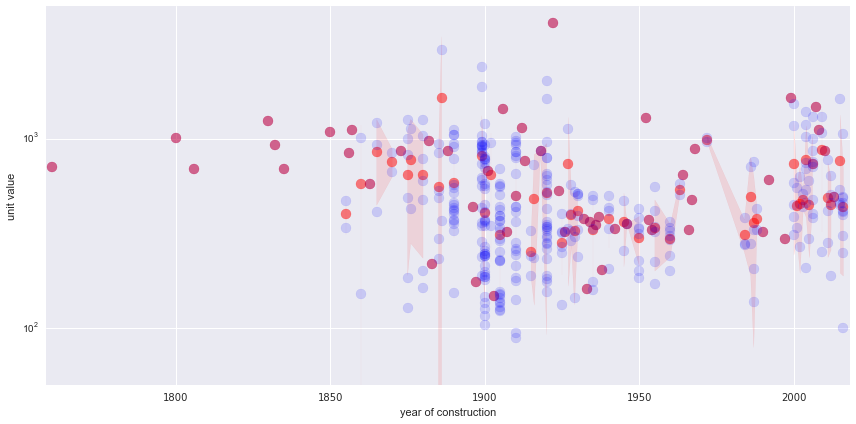

In [379]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), tight_layout=True)

mn=yr_df['mean']
std=yr_df['std']
yr=yr_df.index.values

#red
ax.scatter(yr, mn, color='r', alpha=0.5, s=100)
ax.fill_between(yr, mn-std, mn+std, color='r', alpha=0.1)

#blue
for name, group in dfgb['unit_val']:
    ax.scatter([name] * len(group), group, color='b', alpha=0.15, s=100)
    
#ax.set_xscale('symlog')
ax.set_yscale("log")
ax.set_xlim([1758,2018])
ax.set_ylim([50,5000])
    
ax.set_xlabel('year of construction')
ax.set_ylabel("unit value")

In [380]:
dfgb2 = df.groupby('use')

In [381]:
i = 0

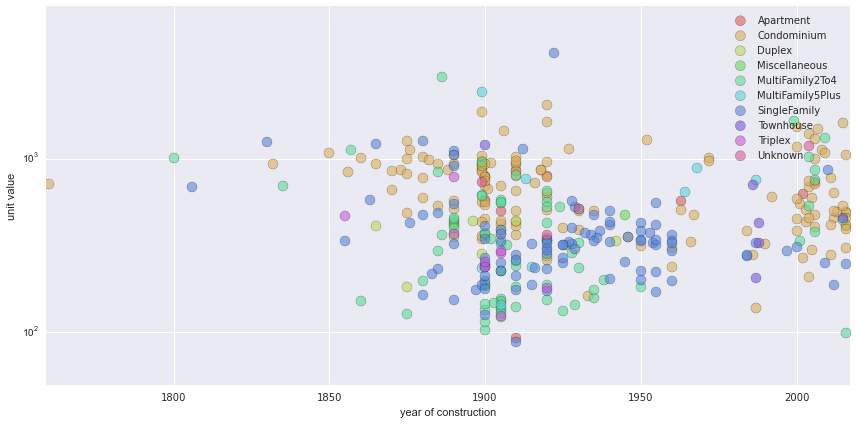

In [382]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), tight_layout=True)

mn=yr_df['mean']
std=yr_df['std']
yr=yr_df.index.values

colors = sns.color_palette("hls", 10) # cubehelix

for i, (name, group) in enumerate(dfgb2): 
    ax.scatter(group['yr'], group['unit_val'], label=name, alpha=0.6, s=100, c=colors[i])    

ax.set_yscale("log")
ax.set_xlim([1759,2017])
ax.set_ylim([50,7500])
ax.legend()
    
ax.set_xlabel('year of construction')
ax.set_ylabel("unit value")

### normalize by "use"

In [411]:
df.loc[df['lat'].idxmax(axis=1)]['url']

'http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id=X1-ZWz1f9f43srdhn_5b1bv&address=166+Orient+Ave&citystatezip=02128'

In [342]:
# remove outlier (error)
df = df.drop(df['Y'].idxmax(axis=1), axis=0)

In [344]:
df.loc[df['Y'].idxmax(axis=1)]['url']

'http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id=X1-ZWz1f9f43srdhn_5b1bv&address=400+Stuart+St&citystatezip=02116'

In [384]:
df['Y'] = df.groupby('use')['unit_val'].transform(lambda x: (x - x.mean()) / x.std() )

### found a record that has wrong coordinates on Zillow...

In [425]:
a = df.sort(columns='lat',ascending=False)
a.head()
print a.loc[273,'url']
df.loc[273,'lat'] = 42.353019
df.loc[273,'lng'] = -71.080864
# http://www.zillow.com/homedetails/295-297-Beacon-St-UNIT-22-Boston-MA-02116/59170661_zpid/
# Current coor: 42.383911,-71.112991; Actual coor: 42.353019, -71.080864

,fsz,lat,lng,rm,sz,url,use,val,yr,price,val-price,unit_val,Y
248,1775,42.390362,-71.006812,7,7500,http://www.zillow.com/webservice/GetDeepSearch...,SingleFamily,566674,1925,649900,566674,319.252958,-0.237480
455,3261,42.385135,-71.002222,NaN,2560,http://www.zillow.com/webservice/GetDeepSearch...,MultiFamily2To4,595365,1910,799900,595365,182.571297,-0.686583
273,1131,42.383911,-71.112991,6,1131,http://www.zillow.com/webservice/GetDeepSearch...,MultiFamily2To4,945649,1885,580000,945649,836.117595,0.813237
299,2908,42.383732,-71.078964,12,3755,http://www.zillow.com/webservice/GetDeepSearch...,Triplex,743523,1900,345000,743523,255.681912,-0.396566
28,900,42.383333,-71.070579,3,435,http://www.zillow.com/webservice/GetDeepSearch...,SingleFamily,436938,1885,449000,436938,485.486667,0.099817


### visualize

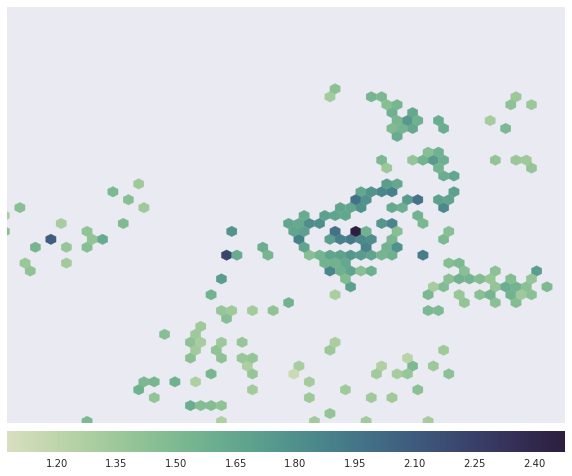

In [430]:
bounds = [-71.16197823, -71.02110553, 42.300087100000006, 42.40502692]

fig = plt.figure(figsize=(10,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(resolution = 'l', 
              epsg=4326,
              llcrnrlon = bounds[0], llcrnrlat = bounds[2], urcrnrlon = bounds[1], urcrnrlat = bounds[3])

cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True) # sns.diverging_palette(220, 20, n=7, as_cmap=True)
minval = np.min(df['Y'])
values = [math.log(x-minval+2.7) for x in df['Y']]

map.hexbin(df['lng'].values, df['lat'].values, C=values, reduce_C_function = np.mean, gridsize = 65, cmap=cmap)

map.colorbar(location='bottom')

plt.show()

# associate property values with image locations (kNN regression)

In [348]:
df_coor = pd.read_csv(dataroot+'deep_test_stats_boston.csv')[['lat','lng']]

In [349]:
df_coor.head()

,lat,lng
0,42.300087,-71.073887
1,42.300087,-71.073887
2,42.300135,-71.099670
3,42.300516,-71.084763
4,42.300516,-71.084763


0.0883769205912


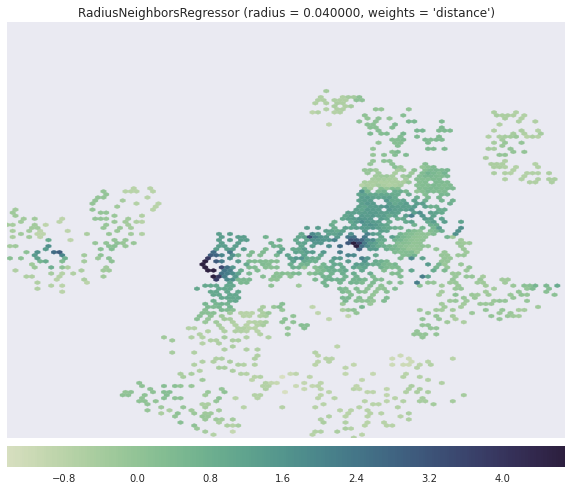

In [429]:
ma = df_coor.max() 
mi = df_coor.min()

X = (df[['lat','lng']] - 0.5*(ma + mi)) / (ma - mi)
T = (df_coor - 0.5*(ma + mi)) / (ma - mi)

y = df['Y']

# Fit regression model
radius = 0.04

nbrs = neighbors.NearestNeighbors(n_neighbors=1, metric='euclidean').fit(X) # radius=radius, 
distances, indices = nbrs.kneighbors(T)

distances = distances.ravel()
print np.mean(distances)
notAlone = distances < radius

T = T[notAlone]
df_coor_valid = df_coor[notAlone]

neigh = neighbors.RadiusNeighborsRegressor(radius=radius, weights='distance')
y_ = neigh.fit(X, y).predict(T)


fig = plt.figure(figsize=(10,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(resolution = 'l', 
              epsg=4326,
              llcrnrlon = bounds[0], llcrnrlat = bounds[2], urcrnrlon = bounds[1], urcrnrlat = bounds[3])

cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True) # sns.diverging_palette(220, 20, n=7, as_cmap=True)
minval = np.min(df['Y'])
values = [math.log(x-minval+2.7) for x in df['Y']]

map.hexbin(df_coor_valid['lng'].values, df_coor_valid['lat'].values, C=y_, reduce_C_function=np.mean, gridsize = 100, cmap=cmap)

map.colorbar(location='bottom')
plt.title("RadiusNeighborsRegressor (radius = %f, weights = '%s')" % (radius, weights))
plt.show()


In [431]:
len(y_)

2570

In [432]:
df_coor.index[notAlone]

Int64Index([   0,    1,    3,    4,    5,    6,    7,    8,    9,   10, 
            ...
            4883, 4903, 4907, 4908, 4909, 4914, 4915, 4916, 4958, 4971],
           dtype='int64', length=2570)

'http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id=X1-ZWz1f9f43srdhn_5b1bv&address=295+Beacon+St&citystatezip=02116'

In [17]:
pd.isnull(df.loc[10,'price'])

True

In [8]:
A = np.random.random((10,2))*100

In [12]:
A

array([[ 57.2887087 ,  72.66973878],
       [ 21.29714509,  19.70625033],
       [ 90.85276812,  16.73142041],
       [ 49.83603819,  60.98579739],
       [ 21.17518368,  54.46858789],
       [ 46.3897464 ,  19.1907922 ],
       [ 35.61530036,  67.42435768],
       [ 60.2044229 ,  42.20668763],
       [ 20.24954128,  30.51849335],
       [  9.09312293,  60.26628969]])

In [9]:
pt = [6, 30]

In [10]:
A[spatial.KDTree(A).query(pt)[1]]

array([ 20.24954128,  30.51849335])

In [13]:
spatial.KDTree(A).query(pt) # distance, index

(14.258971285758975, 8)